In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 
import seaborn as sns

import re
import string as s

from bs4 import BeautifulSoup
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.naive_bayes import MultinomialNB 
import spacy

from wordcloud import WordCloud

from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.metrics import  confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.base import TransformerMixin, BaseEstimator

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import nltk

nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\2024\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\2024\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\2024\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

.\ag-news-classifications.ipynb
.\test.csv
.\train.csv


In [100]:
data_dir = '.' # If run in kaggle replace with actual directory path starting with /kaggle/input or /kaggle/working

In [ ]:
train_data = pd.read_csv(f'{data_dir}/train.csv', header=0,names=['category','title','text'])
test_data = pd.read_csv(f'{data_dir}/test.csv', header=0,names=['category','title','text'])
#df = pd.concat([train_data,test_data])

In [ ]:
print(train_data.shape)
print(test_data.shape)

In [ ]:
train_data.head()

#### <h1 align=center>Visualize all available newsgroups</h1>
<p align=center>Successfully showed the categories available in each of the training & testing data using sns.<br>
Both training & testing data have <strong>4 categories</strong> and the plot clarifies the count of each.</p>

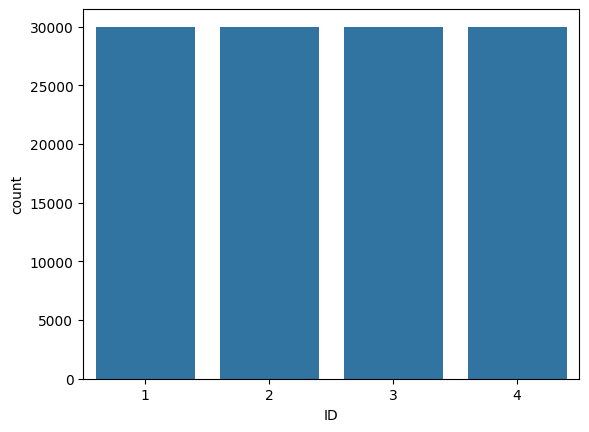

In [ ]:
sns.countplot(x = 'category', data = train_data)
plt.show()

In [ ]:
sns.countplot(x = 'category', data = test_data)
plt.show()

In [ ]:
def plot_wordcloud(data_df, id: int = 1, column='text'):
    _desc = data_df.loc[data_df['category'] == id, column]
    plt.figure(figsize=(6, 6))
    wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(_desc))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


#### <h1 align=center>Apply Text Preprocessing</h1>
Using my customized TextPreprocessor class, I'm able to preprocess data through the pipeline:
- Lowercasing.
- Remove HTML tags & Removal of whitespaces.
- Clear text from urls using regex.
- Tokenization using nltk word_tokenize.
- Lemmatization using nltk WordNet

In [ ]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X, *_):
        return pd.Series(self._preprocess_sentences(X), index=X.index)

    def _preprocess_text(self, text):
        text = text.lower().strip()
        text = BeautifulSoup(text, "html.parser").get_text()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalpha()]
        
        return ' '.join(tokens)
    
    def _preprocess_sentences(self, sentences):
        return sentences.apply(self._preprocess_text)
 
preprocessor = TextPreprocessor()

In [ ]:
train_data.loc[:, 'processed'] = preprocessor.transform(train_data['text'])

In [ ]:
test_data.loc[:, 'processed'] = preprocessor.transform(test_data['text'])

#### <h1 align=center>Visualization of word clouds</h1>
<p align=center>Worked on visualizing the most frequent words per category using WordCloud.</p>

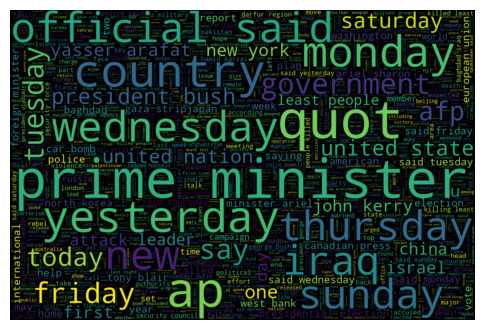

In [39]:
plot_wordcloud(train_data, 1, 'processed')

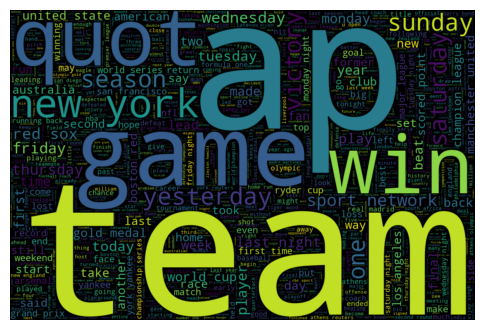

In [40]:
plot_wordcloud(train_data, 2, 'processed')

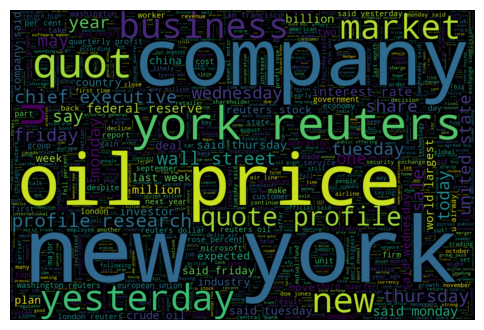

In [41]:
plot_wordcloud(train_data, 3, 'processed')

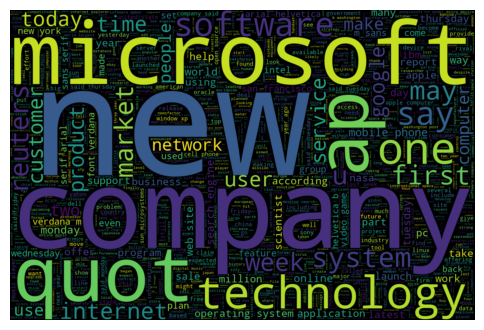

In [42]:
plot_wordcloud(train_data, 4, 'processed')

In [65]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))

In [66]:
X_train = tfidf.fit_transform(train_data['processed'])
X_test = tfidf.transform(test_data['processed'])
print("No. of features extracted:")
print(len(tfidf.vocabulary_))

No. of features extracted:
1022008


In [ ]:
Y_train = train_data['category']
Y_test = test_data['category']

In [96]:
models = [
	{ 
		'model': MultinomialNB(),
		'name': 'Naive Bayes'
	},
	{
		'model':  LGBMClassifier(max_depth=10, num_leaves=127, reg_lambda=0.1, min_split_gain=0.001, min_data_in_leaf=20, random_state=42, n_jobs=-1),
		'name': 'LGBM'
	}
]

In [84]:
def predict(model, size=20):
	model['p'] = model['model'].predict(X_test)
	print(f"First {size} ACTUAL labels")
	print(Y_test.tolist()[:size])
	print(f"First {size} PREDICTED labels")
	print(model['p'].tolist()[:size])


In [85]:
def get_scores(model):
	print(f"F1 score of {model['name']}:")
	f1 = f1_score(Y_test, model['p'], average='micro')
	print(f1)
	print(f"Accuracy of {model['name']}:")
	accuracy = accuracy_score(Y_test, model['p'])
	print(accuracy)
	print(f"Accuracy of {model['name']} in percentage:")
	accuracy_percentage = round(accuracy * 100, 3)
	print(accuracy_percentage, "%")


In [88]:
%%time
models[0]['model'].fit(X_train, Y_train)

CPU times: total: 219 ms
Wall time: 297 ms


,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [89]:
predict(models[0])

First 20 ACTUAL labels
[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
First 20 PREDICTED labels
[3, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3]


In [90]:
get_scores(models[0])

F1 score of Naive Bayes:
0.9
Accuracy of Naive Bayes:
0.9
Accuracy of Naive Bayes in percentage:
90.0 %


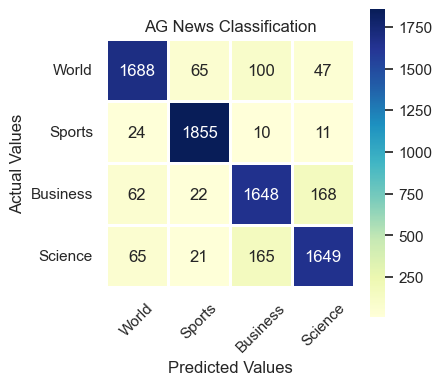

In [72]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['World', 'Sports', 'Business', 'Science'], columns=['World', 'Sports', 'Business', 'Science'])
sns.set(font_scale=1)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix_df, cmap="YlGnBu", linewidths=1, annot=True, square=True, cbar=True, fmt='d')
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("AG News Classification")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [97]:
models[1]['model'].fit(X_train, Y_train)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.833226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 629431
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 17037
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

,boosting_type,'gbdt'
,num_leaves,127
,max_depth,10
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.001
,min_child_weight,0.001
,min_child_samples,20


In [98]:
predict(models[1])

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
First 20 ACTUAL labels
[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
First 20 PREDICTED labels
[3, 4, 4, 2, 2, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 3]


e:\Applications\python-projects\eleevo-internship\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [99]:
get_scores(models[1])

F1 score of LGBM:
0.8656578947368421
Accuracy of LGBM:
0.8656578947368421
Accuracy of LGBM in percentage:
86.566 %
